# Stærðfræði og reiknifræði – Tímadæmi 9 – MNIST gagnasafnið

In [3]:
#BYRJA -- Keyrið til að frumstilla
import numpy as np, numpy.random as npr
import scipy.stats as stat, statsmodels.api as sm, scipy.linalg as la
import matplotlib.pyplot as plt, matplotlib as mpl, struct, gzip
from scipy.cluster.vq import kmeans, whiten, vq
%matplotlib inline
plt.rc('axes', axisbelow=True);
# disp(x,y...) skrifar x,y... með 3 aukastöfum
def disp(*args): print(*(f'{a:.3f}' if isinstance(a,float) else a for a in args))
np.set_printoptions(precision=4, floatmode='fixed', suppress=True, linewidth=150)
mpl.rc('image',cmap='binary')

Í þessum dæmatíma kynnumst við MNIST gagnasafninu (*database*; M = *Modified* og NIST = *National Institute of Standards and Technology*), sem er safn af myndum af alls 70000 handskrifuðum tölustöfum, sem skiptast í 60000 þjálfunarmyndir (*training images*) og 10000 prófunarmyndir (*test images*). Þetta safn er mikið notað til að prófa og þróa ýmis myndvinnslukerfi. Eitt af því sem algengast er að gera með safnið er að láta kerfin þekkja tölustafina með sem lægstri villutíðni. Ástæðan fyrir skiptingunni í *train* og *test* er að geta þjálfað kerfi og prófað það í framhaldinu með gögnum sem ekki hafa komið við sögu í þjálfuninni.

Byrjið á að skoða [lýsingu á safninu](https://en.wikipedia.org/wiki/MNIST_database) á Wikipediu. Stækkið m.a. myndina með sýnishornunum, finnið út stærð hverrar myndar í dílum (*pixels*) og hve lágri villutíðni menn hafa náð. Leysið svo eftirfarandi verkefni með aðstoð frá dæmatímakennara.

## A. Náð í gögnin
Gögnin eru í fjórum skrám sem ég náði í beint frá [heimasíðu safnsins](http://yann.lecun.com/exdb/mnist/). Á Piazza heita þær:

    mnisttrain.gz
    mnistlabel.gz
    mnisttest.gz
    mnisttestlabel.gz
    
Skrárnar eru á svonefndu idx-gzip-sniði og í næsta reit er skilgreint fall sem getur lesið þær.

In [4]:
def lesa_igz(skráarnafn):
    "Skilar fylki með gögnum úr skrá með idx-gzip-sniði"
    with gzip.open(skráarnafn, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

Náið í skrárnar og lesið `mnist-train.gz` og `mnist-label.gz` inn í fylki `train` og `label` og hinar tvær inn í `test` og `tstlbl`. Skrifið út stærðir fylkjanna (með `np.shape`), stak nr. 0 í `train` og stök nr. 0–9 í `label`.

In [5]:
train = lesa_igz('mnisttrain.gz')
label = lesa_igz('mnisttrainlabel.gz')
test = lesa_igz('mnisttest.gz')
tstlbl = lesa_igz('mnisttestlabel.gz')

print(f'Staerd train: {np.shape(train)}')
print(f'Staerd label: {np.shape(label)}')
print(f'Staerd test: {np.shape(test)}')
print(f'Staerd tstlbl: {np.shape(tstlbl)}')
print( train[0] )
print( label[0:10] )

Staerd train: (60000, 28, 28)
Staerd label: (60000,)
Staerd test: (10000, 28, 28)
Staerd tstlbl: (10000,)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56

## B. Teiknaðar myndir
Í næsta reit er fall til að sýna nokkrar tölustafamyndir í einu. Hægt er að kalla á þetta fall með `sýnamyndir(listi)` þar sem listi er listi eða vigur af myndum (t.d. `sýnamyndir(train[0:4])`) og þá teiknar það myndirnar í samsettri mynd (*figure*), 10 myndir í hverri línu. Teiknið fyrstu 40 myndirnar í `train` og fyrstu 10 í `test`.

In [8]:
def synamyndir(list, n=10, width=16):
    """Birtir myndir list[0], list[1]... í samsettri mynd, n í hverri línu"""
    l = len(list)
    m = (l-1)//n + 1
    plt.figure(figsize=(width, width*m/n))
    if np.ndim(list) == 2:
        list = np.reshape(list, (-1,28,28))
    for i in range(l):
        plt.subplot(m, n, i+1)
        plt.imshow(list[i])
        plt.xticks([]); plt.yticks([])

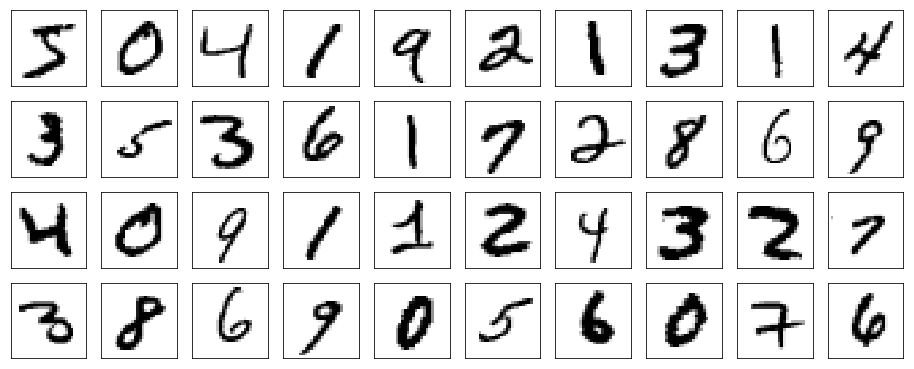

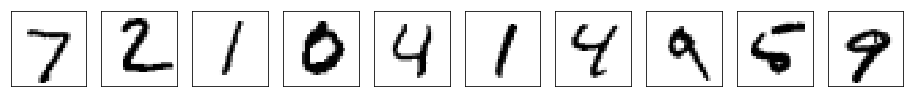

In [9]:
synamyndir(train[0:40])
synamyndir(test[0:10])

## C. Útreikningur "meðaltölustafa"
Ein leið til að búa til reiknirit til að þekkja tölustafi er að búa til **fulltrúa** fyrir hvern tölustaf, t.d. með því að reikna meðaltal (eða þungamiðju, *centroid*) af öllum myndum af stafnum, í anda þess sem gert er í *k-means*. Það er auðvelt að gera með *komprehensjón* og `np.mean`. Ef maður skrifar `np.mean(A,0)` (*mean* yfir vídd 0) þar sem `A` er safn mynda þá skilar það meðaltali myndanna, og með því að skrifa t.d. `A = train[label==0]` fær maður í `A` allar myndir af núllum. Svo er snið á *komprehensjón* svona: `x = segð-með-i for i in range(n)`. Búið til lista `M` með 10 myndum, þannig að `M[i]` sé mynd af tölustafnum `i`. Teiknið myndirnar með `sýnamyndir`. Fáið hjálp hjá dæmatímakennara.

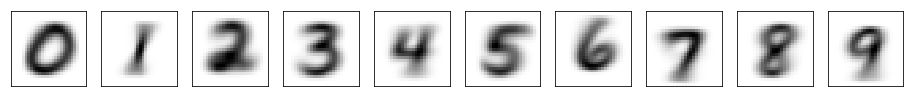

In [22]:
#trainA = vectorize(train)
#print(np.shape(trainA))
#(cbi,_) = kmeans(trainA,10)
#cbi
#m = [x for x in range(10)]
#print(m)
M = [np.mean(train[label==i],0) for i in range(10)]
synamyndir(M)

## D. Flokkun með VQ
Í næsta reit er fall sem breytir hverri mynd í vigur, og ef það er gert bæði við `train`-fylkið og `M`-fylkið er hægt að nota `vq`-fallið til að flokka myndirnar, þannig að hver mynd sé sett í flokk með þeim fulltrúa sem er næstur henni miðað við Evklíðska fjarlægð (þ.e. normið af mismun vigranna sem svara til myndarinnar og fulltrúans). Fylkið sem búið er til úr `M` gegnir þá hlutverki *code-book* þegar k-means er notað. Í reitnum er búið að búa til bæði fylki `X` úr `train`-fylkinu og fylki `cb` úr `M`-fylkinu. 

Við getum t.d. skoðað fjarlægð `X[0]` frá öllum myndunum í `M` með `la.norm(X[0] - cb, axis=1)` og skoðað hvaða mynd er næst `X[0]`. Passar niðurstaðan? Skoðið líka víddirnar á X og cb. 

Notið nú í framhaldi `vq`-fallið til að flokka allar myndirnar í X og finnið út hve stórt hlutfall er rétt flokkað (ef `spáð` er flokkunin sem kemur út úr `vq` þá gefur `sum(spáð != label)` fjölda mynda sem flokkast rangt). Teiknið líka úrval rangt flokkaðra mynda (þær fást með `train[spáð != label]`)

In [28]:
def vectorize(x):
    """Breytir hverri mynd í x í float vigur
    Ef shape(x) er (k,28,28) er skilað fylki með k línum og 784 dálkum (28*28=784)"""
    return np.reshape(x, (len(x),28*28)).astype(float)

X = vectorize(train)
cb = vectorize(M)

[2073.8305 2115.3318 2021.5502 1758.9296 2183.8364 1707.1523 2033.6756 1988.2263 1882.5042 2014.2938]


[5 0 4 1 9 2 1 3 1 4]
19.201666666666668


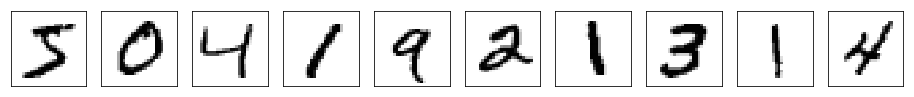

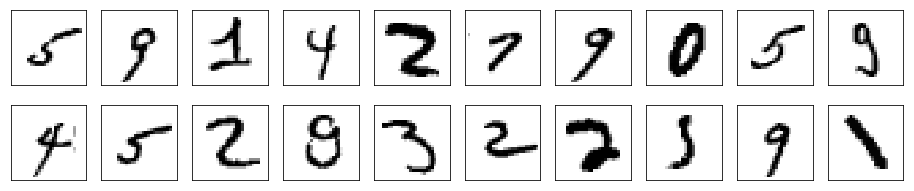

In [33]:
(spad, _) = vq(X, cb)
synamyndir(X[0:10])
print(spad[0:10])
rangar = train[spad != label]
hlutf = 100*len(rangar)/len(train)
print(hlutf)
synamyndir(rangar[0:20])

## E. Mismunandi fjarkar
Einn möguleiki til að ná betri árangri við flokkunina er að átta sig á að það eru nokkrir flokkar af hverjum tölustaf, T.d. 1 með hallandi striki efst og án, 7 með striki og án, 9 með beinu striki og bognu, 4 sem lokast efst eða ekki. Til að finna þessa flokka mætti nota *k-means* aðferð á allar myndir af hverjum staf. Í framhaldi má búa til nýja "code-book" með öllum flokkunum fyrir allar tölurnar, en hér látum við duga að flokka fjarkana.

Náið í alla fjarkana með `X4 = X(label==4)`. Til að `kmeans` verði ekki of lengi að keyra má fækka fjörkunum t.d. með `X4 = X4[:2000]`. Notið svo `kmeans` til að finna 10 fjarkaflokka og teiknið fulltrúana sem finnast.

fjarker eru 5842


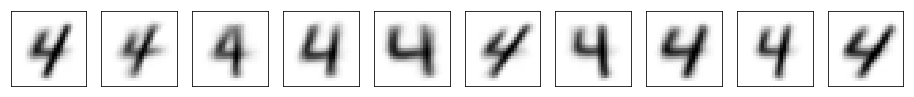

In [34]:
X4 = X[label==4]
disp('fjarker eru', len(X4))
(cb4,_) = kmeans(X4[:2000],10)
synamyndir(cb4)